<a href="https://colab.research.google.com/github/ranjith13119/Attention-MultiClassText-Classification/blob/main/Attention_Seq2Seq_MultiClassTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import csv
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
dataset = pd.read_csv("/content/drive/MyDrive/NLP/MultiClass Classification LSTM/bbc-text.csv")

In [107]:
dataset.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [108]:
dataset.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [109]:
df = dataset.copy()

In [110]:
df.category = df.category.map({ 
    "sport" : 1,
    "business" : 2,
    "politics" : 3, 
    "tech" : 4, 
     "entertainment" : 5           
})

In [111]:
df.head()

,category,text
0,4,tv future in the hands of viewers with home th...
1,2,worldcom boss left books alone former worldc...
2,1,tigers wary of farrell gamble leicester say ...
3,1,yeading face newcastle in fa cup premiership s...
4,5,ocean s twelve raids box office ocean s twelve...


In [112]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [113]:
def clean_text(text):
    '''
      This function will return the processed review texts
    '''
    text = re.sub(r'[^\w\s]','',text, re.UNICODE) 
    text = text.lower()
    text = text.replace(' ', '')
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text] # find the lemma word
    text = [word for word in text if  not word in stop_words] # remove the english stop words
    text = " ".join(text)
    return text

In [114]:
df['preprossed_data'] = df.text.apply(lambda x : clean_text(x))

In [115]:
df['preprossed_data'].apply(lambda x : len(x.split(" "))).mean()

1.0

In [116]:
MAX_FEATURES = 6000  # vocab size
EMBED_SIZE = 260
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(df['preprossed_data'])
list_tokenized_train = tokenizer.texts_to_sequences(df['preprossed_data']) # convert the text into sequence of token vectors

RNN_CELL_SIZE = 32
  
MAX_LEN = 260  # Since our mean length is 127.98498
X = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y = df['category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3 ,random_state = 42)

In [117]:
X_test.shape

(742, 260)

In [118]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #@eq.4 w1
        self.W2 = tf.keras.layers.Dense(units) #@eq.4 w2
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):

        # we are doing this to perform addition to calculate the score
        # expand_dims will not add or reduce elements in a tensor, it just changes the shape by adding 1 to dimensions. 
        # For example, a vector with 32 elements could be treated as a 32x1 matrix

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)

        score = tf.nn.tanh( self.W1(features) + self.W2(hidden_with_time_axis)) #@eq.4b
        attention_weights = tf.nn.softmax(self.V(score), axis=1) # to make the feedforward weight to 1
          
        context_vector = attention_weights * features # multiply the wieight with features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # calculate all the weight and send it to output
        return context_vector, attention_weights

In [119]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [120]:
# Input as a LSTM
# rune the bidirectional LSTM with batch size as 32
# LSTM1, i'm only returning the sequence of vectors not the state
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [121]:
state_h = Concatenate()([forward_h, backward_h]) # combining both direction outputs
state_c = Concatenate()([forward_c, backward_c])  # combining both direction hidden cell states

In [122]:
# context_vector  -> tokenized context vector from the attension layer
# attention_weights -> all the attension weights
context_vector, attention_weights = Attention(10)(lstm, state_h) 
dense1 = Dense(units=64, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1) # adding dropout layer to avoid overfittingmodel = keras.Model(inputs=sequence_input, outputs=output)
output = Dense(5, activation='softmax')(dropout) # we are using sigmoid activation function as our output is binary classification

In [123]:
model = keras.Model(inputs=sequence_input, outputs=output)

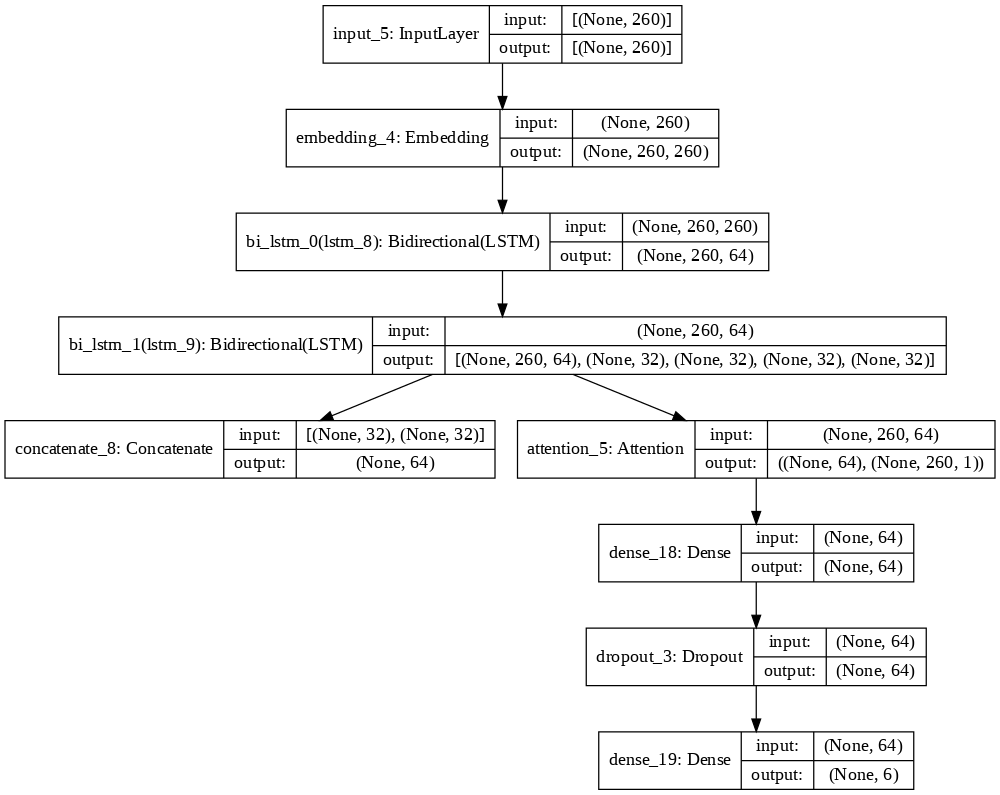

In [124]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [125]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [126]:
X_train.shape , y_train.shape

((1483, 260), (1483,))

In [127]:
y_train.value_counts()

1    351
2    328
3    290
4    258
5    256
Name: category, dtype: int64

In [ ]:
BATCH_SIZE = 100
EPOCHS = 100
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/100
12/12 [==============================] - 15s 806ms/step - loss: 1.7058 - accuracy: 0.2201 - val_loss: 1.6218 - val_accuracy: 0.2222
Epoch 2/100
12/12 [==============================] - 8s 693ms/step - loss: 1.6278 - accuracy: 0.2218 - val_loss: 1.6055 - val_accuracy: 0.2424
Epoch 3/100
12/12 [==============================] - 8s 685ms/step - loss: 1.6218 - accuracy: 0.2445 - val_loss: 1.6122 - val_accuracy: 0.2222
Epoch 4/100
12/12 [==============================] - 8s 683ms/step - loss: 1.6152 - accuracy: 0.2344 - val_loss: 1.6037 - val_accuracy: 0.2424
Epoch 5/100
12/12 [==============================] - 8s 685ms/step - loss: 1.6131 - accuracy: 0.2159 - val_loss: 1.6046 - val_accuracy: 0.2222
Epoch 6/100
 7/12 [================>.............] - ETA: 3s - loss: 1.6079 - accuracy: 0.2400

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
txt = ["kennedy questions trust of blair lib dem leader charles kennedy has said voters now have a  fundamental lack of trust  of tony blair as prime minister.  he said backing his party"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)-1])
